# Multi-GPU Training with Caffe2 

![caffe2 imagenet logo](images/caffe2-imagenet.png)

For this tutorial we will explore multi-GPU training. We will show you a basic structure for using the `data_parallel_model` to quickly process a subset of the ImageNet database along the same design as the [ResNet-50 model](https://arxiv.org/abs/1512.03385). We will also get a chance to look under the hood at a few of Caffe2's C++ operators that efficiently handle your image pipeline, build a ResNet model, train on a single GPU and show some optimizations that are included with `data_parallel_model`, and finally we'll scale it up and show you how to parallelize your model so you can run it on multiple GPUs.

## About the Dataset

A commonly used dataset for benchmarking image recognition technologies is [ImageNet](http://image-net.org/). It is huge. It has images that cover the gamut, and they're categorized by labels so that you can create image subsets of animals, plants, fungi, people, objects, you name it. It's the focus of yearly competitions and this is where deep learning and convolutional neural networks (CNN) really made its name. During the 2012 ImageNet Large-Scale Visual Recognition Challenge a CNN demonstrated accuracy more than 10% beyond the next competing method. Going from around 75% accuracy to around 85% accuracy when every year the gains were only a percent or two is a significant accomplishment. 

![imagenet montage](images/imagenet-montage.jpg)

So let's play with ImageNet and train our own model on a bunch of GPUs! You're going to need a lot space to host the 14 million images in ImageNet. How much disk space do you have? You should clear up about 300GB of space... on SSD. Spinning discs are so 2000. How much time do you have? With two GPUs maybe we'll be done in just under a week. Ready?

![one does not simply train imagenet in a minute](images/imagenet-meme.jpg)

That's way too much space and way too long for a tutorial! If you happened to have that much space and 128 GPUs on the latest NVIDIA V100's then you're super awesome and you can replicate our recent results shown below. You might even be able to train ImageNet in under an hour. Given how this performance seems to scale, **maybe YOU can train ImageNet in a minute!** Think about all of the things you could accomplish... a model for millions of hours of video? Catalogue every cat video on YouTube? Look for your doppleganger on Imgur?

Instead of tons of GPUs and the full set of data, we're going to do this cooking show style. We're going to use a small batch images to train on, and show how you can scale that up. We chose a small slice of ImageNet: a set of 640 cars and 640 boats for our training set. We have 48 cars and 48 boats for our test set. This makes our database of images around 130 MB.

## ResNet-50 Model Training Overview

Below is an overview of what is needed to train and test this model across multiple GPUs. You see that it is generally not that long, nor is it that complicated. Some of the interactions for creating the parallelized model are handled by custom functions you have to write and we'll go over those later.

1. use `cnn.CNNModelHelper` to create a model for training (we'll create one for testing later)
2. create a database reader using the model helper object's `CreateDB` to pull the images
3. create functions to run a ResNet-50 model for one or more GPUs
3. create the parallelized model
4. loop through the number of epochs you want to run, then for each epoch
    * run the train model till you finish each batch of images
    * run the test model
    * calculate times, accuracies, and display the results

## Part 1: Setup

Your first assignment is to get your training and testing image database setup. We've created one for you and all you have to do run the code block below. This assumes you know how to use IPython. When we say run a code block, you can click the block and hit the Play button above or hit Ctrl-Enter on your keyboard. If this is news to you it is advisable that you start with introductory tutorials and get used to IPython and Caffe2 basics first.

The code below will download a small database of boats and cars images and their labels for you if it doesn't already exist. The images were pulled from ImageNet and added to a `lmdb` format database. You can download it directly [here](https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip) unzip it, and change the folder locations to an NFS if that better suits your situation. The tutorial's default location is for you to place it in `~/caffe2_notebooks/tutorial_data/resnet_trainer`.

You can also swap out the database with your own as long as it is in lmdb and you change the `train_data_count` and `test_data_count` variables below. For your first time just use that database we made for you.

We're going to give you all the dependencies needed for the tutorial in the block below. 

### Task: Run the Setup Code
Read and then run the code block below. Note what modules are being imported and where we're accessing the database. Note and troubleshoot any errors in case something is wrong with your environment. Don't worry about the `nccl` and `gloo` warning messages.


In [76]:
from caffe2.python import core, workspace, cnn, net_drawer, memonger
from caffe2.python import data_parallel_model as dpm
from caffe2.python.models import resnet
from caffe2.proto import caffe2_pb2

import numpy as np
import time
import os
from IPython import display
    
workspace.GlobalInit(['caffe2', '--caffe2_log_level=2'])

# This section checks if you have the training and testing databases
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'resnet_trainer')

# Train/test data
train_data_db = os.path.join(data_folder, "imagenet_cars_boats_train")
train_data_db_type = "lmdb"
# actually 640 cars and 640 boats = 1280
train_data_count = 1280
test_data_db = os.path.join(data_folder, "imagenet_cars_boats_val")
test_data_db_type = "lmdb"
# actually 48 cars and 48 boats = 96
test_data_count = 96

# Get the dataset if it is missing
def DownloadDataset(url, path):
    import requests, zipfile, StringIO
    print("Downloading {} ... ".format(url))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Done!")

# Make the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
# See if you already have to db, and if not, download it
if not os.path.exists(train_data_db):
    DownloadDataset("https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip", data_folder) 

Done!


### Task: Check the Database

Take a look at your `~/caffe2_notebooks/tutorial_data/resnet_trainer` folder. You should find two subfolders, each of which will contain a single `data.mdb` file (or possibly also a lock file):
1. imagenet_cars_boats_train (train for training, not locomotives!)
2. imagenet_cars_boats_val (val for validation or testing)

## Part 2: Configure the Training

Below you can tinker with some of the settings for how the model will be created. One obvious setting to try is the `gpus`. By removing one or adding one you're directly impacting the amount of time it will take to run even on this small dataset.

`batch_per_device` is the number of images processed at a time on each GPU. Using the default of 32 for 2 GPUs will equate to 32 images on each GPU for a total of 64 per mini-batch, so we'll go through the whole database and complete an epoch in 20 iterations. This is something you would want to adjust if you're sharing the GPU or otherwise want to adjust how much memory this training run is going to take up. You can see in the line below it being set to `32` we're adjusting the `total_batch_size` based on the number of GPUs.

`base_learning_rate` and `weight_decay` will both influence training and can be interesting to change and witness the impact on accuracy or confidence is the results that are shown in the last section of this tutorial.



In [ ]:
# Configure how you want to train the model and with how many GPUs
# This is set to use two GPUs in a single machine, but if you have more GPUs, extend the array [0, 1, 2, n]
gpus = [0]

# Batch size of 32 sums up to roughly 5GB of memory per device
batch_per_device = 32
total_batch_size = batch_per_device * len(gpus)

# This model discriminates between two labels: car or boat
num_labels = 2

# Initial learning rate (scale with total batch size)
base_learning_rate = 0.0004 * total_batch_size

# only intends to influence the learning rate after 10 epochs
stepsize = int(10 * train_data_count / total_batch_size)

# Weight decay (L2 regularization)
weight_decay = 1e-4

## Part 3: 

### Using Caffe2 Operators to Create a CNN

Caffe2 comes with a nice helper function in the [cnn class](https://caffe2.ai/docs/cnn.html) called `CNNModelHelper` which will do a lot of the heavy lifting for you when setting up a model. Throughout the docs and tutorial this may also be called a `model helper object`. The only required parameter is `name`. It is an arbitrary name for referencing the network in your workspace: you could call it tacos or boatzncarz. For example:

```python
taco_model = cnn.CNNModelHelper(name="tacos")
```

An optional parameter for `CNNModelHelper` is the image formating `order`. When using GPUs it is fastest to use `order=NCHW` (Number, Channel, Height, Width). Even though this is optional you should set it for multi-GPU training.


```
taco_model = cnn.CNNModelHelper(name="tacos", order="NCHW")
```

You should also reset your workspace if you run these parts multiple times. Do this just before creating the new model helper object.

```
workspace.ResetWorkspace()
```

### Reading from the Database

Another handy function for feeding your network with images is `CreateDB`, which in this case we need to serve as a database reader for the database we've already created. You can create a reader object like this: 

```
reader = taco_model.CreateDB(name, db, db_type)
```

### Task: Create a Model Helper Object
Remember, we have two databases and each will have their own model, but for now we only need to create the training model for the training db. Use the Work Area below. Also, while you do this, experiment with IPython's development hooks by typing the first part of the name from the imported class or module and hitting the tab key. For example when creating the object you type: `train_model = cnn.` and after the dot, hit "tab". You should see a full list of available functions. Then when you choose `CNNModelHelper` hit "(" then hit tab and you should see a full list of params. This is very handy when you're exploring new modules and their functions!

### Task: Create a Reader
We also need one reader. We have established the db location, `train_data_db`, and type, `train_data_db_type`, in "Part 1: Setup", so all you have to do is name it and pass in the configs. Again, `name` is arbitrary so you could call it "kindle" if you wanted. Use the Work Area below, and when you are finished run the code block.

In [ ]:
# LAB WORK AREA FOR PART 3

# 1. Create your model helper object for the training model with CNNModelHelper



# 2. Create your database reader with CreateDB




## Part 4: Image Transformations

Now that we have a reader we should take a look at how we're going to process the images. Since images that are found in the wild can be wildly different sizes, aspect ratios, and orientations we can and should train on as much variety as we can. ImageNet is no exception here. The average resolution is 496x387, and as interesting as that factoid might be, the bottle line is that you have a lot of variation. 

As the training images are ingested we would want to conform them to a standard size. The most direct process of doing so could follow a simple ingest where you transform the image to 256x256. We talked about the drawbacks of doing this in [Image Pre-Processing](Image_Pre-Processing_Pipeline.ipynb). Therefore for more accurate results, we should probably rescale, then crop. Even this approach with cropping has the drawbacks of losing some info from the original photo. What get chopped off doesn't make into the training data. If you ran the pre-processing tutorial on the image of the astronauts you will recall that some of the astronauts didn't make the cut. Where'd they go? Wash-out lane? Planet of the Apes? If your model was to detect people, then those lost astronauts would not be getting due credit when you run inference or face detection later using the model.

### Introducing... the ImageInput Operator

What could be seen as a loss turns into an opportunity. You can crop randomly around the image to create many deriviates of the original image, boosting your training data set, thereby adding robustness to the model. What if the image only has half a car or the front of a boat? You still want your model to be able to detect it! In the image below only the front a boat is shown and the model shows a 50% confidence in detection.

![boat image](images/tutorial-boat.png)

Caffe2 has a solution for this in its [`ImageInput` operator](https://github.com/caffe2/caffe2/blob/master/caffe2/image/image_input_op.h), a C++ image manipulation op that's used under the hood of several of the Caffe2 Python APIs.

Here is a reference implementation:

```python
def add_image_input(model):
    # utilize the ImageInput operator to prep the images
    data, label = model.ImageInput(
        reader,
        ["data", "label"],
        batch_size=batch_per_device,
        # mean: to remove color values that are common
        mean=128.,
        # std is going to be modified randomly to influence the mean subtraction
        std=128.,
        # scale to rescale each image to a common size
        scale=256,
        # crop to the square each image to exact dimensions
        crop=224,
        # mirroring of the images will occur randomly
        mirror=1
    )
    # prevent back-propagation: optional performance improvement; may not be observable at small scale
    data = model.StopGradient(data, data)
```

* mean: remove info that's common in most images
* std: used to create a randomization for both cropping and mirroring
* scale: downres each image so that its shortest side matches this base resolution
* crop: the image size we want every image to be (using random crops from the scaled down image)
* mirror: randomly mirror the images so we can train on both representations

The [`StopGradient` operator](https://caffe2.ai/docs/operators-catalogue.html#stopgradient) does no numerical computation. It is used here to prevent back propagation which isn't wanted in this network.

### Task: Implement the InputImage Operator
Use the Work Area below to finish the stubbed out function. Refer to the reference implementation for help on this task. 

* What happens if you don't add a mean, don't add a std, or don't mirror. How does this change your accuracy when you run it for many epochs?
* What would happen if we didn't do StopGradient?

In [ ]:
# LAB WORK AREA FOR PART 4

def add_image_input(model):
    raise NotImplementedError #remove this from the function stub
    

## Part 5: Creating a Residual Network

Now you get the opportunity to use Caffe2's Resnet-50 creation function! During our Setup we `from caffe2.python.models import resnet`. We can use that for our `create_resnet50_model_ops` function that we still need to create and the main part of that will be the `resnet.create_resnet50()` function as described below:

```python
create_resnet50 (
    model, 
    data, 
    num_input_channels, 
    num_labels, 
    label=None, 
    is_test=False, 
    no_loss=False, 
    no_bias=0, 
    conv1_kernel=7, 
    conv1_stride=2, 
    final_avg_kernel=7
)
```

Below is a reference implementation of the function using `resnet.create_resnet50()`.

```python
def create_resnet50_model_ops(model, loss_scale):
    # Creates a residual network
    [softmax, loss] = resnet.create_resnet50(
        model,
        "data",
        num_input_channels=3,
        num_labels=num_labels,
        label="label",
    )
    prefix = model.net.Proto().name
    loss = model.Scale(loss, prefix + "_loss", scale=loss_scale)
    model.Accuracy([softmax, "label"], prefix + "_accuracy")
    return [loss]
```

### Task: Implement the forward_pass_builder_fun Using Resnet-50
In the code block above where we stubbed out the `create_resnet50_model_ops` function, utilize `resnet.create_resnet50()` to create a residual network, then returning the loss. Refer to the reference implementation for help on this task.

* Bonus points: if you take a look at the resnet class in the Caffe2 docs you'll notice a function to create a 32x32 model. Try it out.

In [ ]:
# LAB WORK AREA FOR PART 5

def create_resnet50_model_ops(model, loss_scale):
    raise NotImplementedError #remove this from the function stub
    

## Part 6: Make the Network Learn


Caffe2 model helper object has several built in functions that will help with this learning by using backpropagation where it will be adjusting weights as it runs through iterations.

* AddWeightDecay
* Iter
* net.LearningRate

Below is a reference implementation:

```
def add_parameter_update_ops(model):
    model.AddWeightDecay(weight_decay)
    # (stepsize moved to config)
    # stepsize = int(10 * train_data_count / total_batch_size)
    iter = model.Iter("iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=stepsize,
        gamma=0.1,
    )
    # momentum SGD update
    for param in model.GetParams():
        param_grad = model.param_to_grad[param]
        param_momentum = model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # netsterov is a defenseman for the Montreal Canadiens, but
            # Nesterov Momentum works slightly better than standard momentum
            nesterov=1,
        )
```

### Task: Implement the forward_pass_builder_fun Using Resnet-50
Several of our Configuration variables will get used in this step. Take a look at the Configuration section from Part 2 and refresh your memory. We stubbed out the `add_parameter_update_ops` function, so to finish it, utilize `model.AddWeightDecay` and set `weight_decay`. Calculate your stepsize using `int(10 * train_data_count / total_batch_size)` or pull the value from the config. Instantiate the learning iterations with `iter = model.Iter("iter")`. Use `model.net.LearningRate()` to finalize your parameter update operations. You can optionally update you SGD's momentum. It might not make a difference in this small implementation, but if you're gonna go big later, then you'll want to do this.

Refer to the reference implementation for help on this task.


In [ ]:
# LAB WORK AREA FOR PART 6

def add_parameter_update_ops(model):
    raise NotImplementedError #remove this from the function stub
    

## Part 7: Gradient Optimization

If you run the network as is you may have issues with memory. Without memory optimization we could reduce the batch size, but we shouldn't have to do that. Caffe2 has a `memonger` function for this purpose which will find ways to reuse gradients that we created. Below is a reference implementation.

```python
def optimize_gradient_memory(model, loss):
    model.net._net = memonger.share_grad_blobs(
        model.net,
        loss,
        set(model.param_to_grad.values()),
        # we don't have a namescope in this case, but let's make one up: we'll need it later!
        namescope="imonaboat",
        share_activations=False,
        )
```

### Task: Implement memonger
We're going to use the reference for help here, otherwise it is a little difficult to cover for the scope of this tutorial. The function is ready to go for you, but you should still soak up what's been done in this function. One of the key gotchas here is making sure you give it a namescope so that you can access the gradients you'll be creating in the next step. This name can be anything.


In [ ]:
# LAB WORK AREA FOR PART 7

def optimize_gradient_memory(model, loss):
    model.net._net = memonger.share_grad_blobs(
        model.net,
        loss,
        set(model.param_to_grad.values()),
        namescope="imonaboat",
        share_activations=False,
        )
    

## Part 8: Training the Network with One GPU

Now that you've established be basic components to run ResNet-50, you can try it out on one GPU. Now, this could be a lot easier just going straight into the `data_parallel_model` and all of its optimizations, but to help explain the components needed and to build the helper functions to run `GPU_Parallelize`, we may as well start simple! 

If you're paying attention you might be wondering about the `gpus` array we made in the config and how that might throw things off. Also, when we looked at the config earlier you may have updated `gpus[0]` to have more than one GPU. That's fine. We can leave it like that for the next part because we will force our script to use just one GPU.

Let's stitch together those functions from Parts 4-7 to run our residual network! Take a look at the code below, so you understand how the pieces fit together.

```python
# We need to give the network context and force it to run on the first GPU even if there are more.
device_opt = core.DeviceOption(caffe2_pb2.CUDA, gpus[0])
# Here's where that NameScope comes into play
with core.NameScope("imonaboat"):
    # Picking that one GPU
    with core.DeviceScope(device_opt):
        # Run our reader, and create the layers that transform the images
        add_image_input(train_model)
        # Generate our residual network and return the losses
        losses = create_resnet50_model_ops(train_model)
        # Create gradients for each loss
        blobs_to_gradients = train_model.AddGradientOperators(losses)
        # Kick off the learning and managing of the weights
        add_parameter_update_ops(train_model)
    # Optimize memory usage by consolidating where we can
    optimize_gradient_memory(train_model, [blobs_to_gradients[losses[0]]])

# Startup the network 
workspace.RunNetOnce(train_model.param_init_net)
# Load all of the initial weights; overwrite lets you run this multiple times
workspace.CreateNet(train_model.net, overwrite=True)
```

### Task: Pull It All Together & Run It!

Things are getting a little hairy, so we gave you the full reference ready to go. Just run the code block below (hit ctrl-enter). Normally you might not use `overwrite=True` since that could be bad for what you're doing by accidentally erasing your earlier work, so try removing it and running the block multiple times to see what happens. Imagine the case where you have multiple networks going that have the same name. You don't want to overwrite, so you might want to start up a new workspace or modify the names.

In [ ]:
# LAB WORK AREA FOR PART 8

device_opt = core.DeviceOption(caffe2_pb2.CUDA, gpus[0])
with core.NameScope("imonaboat"):
    with core.DeviceScope(device_opt):
        add_image_input(train_model)
        losses = create_resnet50_model_ops(train_model)
        blobs_to_gradients = train_model.AddGradientOperators(losses)
        add_parameter_update_ops(train_model)
    optimize_gradient_memory(train_model, [blobs_to_gradients[losses[0]]])


workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

## Part 8 ... part ~~2~~ Duex: Train!
Here's the fun part where you can tinker with the number of epochs to run and mess with the display. We'll leave this for you to play with as a fait accompli since you worked so hard to get this far!

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1
        
        # Stopwatch stopped! How'd we do?
        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))

## Part 9: Getting Parallelized 

You get bonus points if you can say "getting parallelized" three times fast without messing up. You just saw some interesting numbers in the last step. Take note of those and see how things scale up when we use more GPUs. 

We're going to use Caffe2's `data_parallel_model` and its function called `Parallelize_GPU` to help us accomplish this task. The task to setup the parallel model, not to say it fast. Here's the spec on `Parallelize_GPU`:

```
Parallelize_GPU (
    model_helper_obj, 
    input_builder_fun, 
    forward_pass_builder_fun, 
    param_update_builder_fun, 
    devices=range(0, 
    workspace.NumCudaDevices()), 
    rendezvous=None, 
    net_type='dag', 
    broadcast_computed_params=True, 
    optimize_gradient_memory=False)
```

We're not ready to just call this function though. As you can see in the second, third, and fourth input parameters, they are expecting functions to be passed to them. [More API details here.](https://caffe2.ai/doxygen-python/html/namespacedata__parallel__model.html#a1fe7262a0a66754f19998fa1603317b9) The three functions expected are:

1. `input_build_fun`: adds the input operators. Note: Remember to instantiate reader outside of this function so all GPUs share same reader object. Signature:  input_builder_fun(model) [FIX THIS? model->reader]
2. `forward_pass_builder_fun`: adds the operators to the model. Must return list of loss-blob references that are used to build the gradient. Loss scale parameter is passed, as you should scale the loss of your model by 1.0 / the total number of gpus. Signature: forward_pass_builder_fun(model, loss_scale)
3. `param_update_builder_fun`: adds operators that are run after gradient update, such as updating the weights and weight decaying. Signature: param_update_builder_fun(model)

For the `input_build_fun` we're going to use the reader we created with `CreateDB` along with a function that leverages Caffe2's `ImageInput` operator. Sound familiar? You already did this in Part 4!

For the `forward_pass_builder_fun` we need to have residual neural network. You already did this in Part 5!

For the `param_update_builder_fun` we need a function to adjust the weights as the network runs. You already did this in Part 6! 

Let's stub out the `Parallelize_GPU` function with the parameters that we're going to use. Recall that in the setup we  `from caffe2.python import data_parallel_model as dpm`, so we can use `dpm.Parallelize_GPU()` to access the `Parallelize_GPU` function. First we'll stub out the three other functions to that this expects, add the params based on these functions names and our gpu count, then come back to the lab cell below to populate them with some logic and test them. Below is a reference implementation:

```python
dpm.Parallelize_GPU(
    train_model,
    input_builder_fun=add_image_input_ops,
    forward_pass_builder_fun=create_resnet50_model_ops,
    param_update_builder_fun=add_parameter_update_ops,
    devices=gpus,
    optimize_gradient_memory=True,
)
```

### Task: Make Your Helper Functions
You already did this the Parts 4 through 6 and in Part 7 you had to deal with gradient optimizations that are baked into `Parallelize_GPU`. The three helper function stubs below can be eliminated or if you want to see everything together go ahead and copy the functions there, so you can run them from the work area block below.

### Task: Parallelize!
Now you can stub out a call to `Parallelize_GPU`. Use the reference implementation above if you get stuck.
* `model_helper_object`: created in Part 3; maybe you called it taco_model, or if you weren't copying and pasting you thoughtfully called it train_model or training_model.
* Now pass the function name for each of the three functions you just created, e.g. `input_builder_fun=add_image_input_ops`
* `devices`: we can pass in our `gpus` array from our earlier Setup.
* `optimize_gradient_memory`: the default is `False` but let's set it to `True`; this takes care of what we had to do in Step 7 with `memonger`.
* other params: ignore/don't pass anything to accept their defaults


In [ ]:
# LAB WORK AREA for Part 9

# Create input_build_fun
def add_image_input_ops(model):
    # This will utilize the reader to pull images and feed them to the training model's helper object
    # Use the model.ImageInput operator to load data from reader & apply transformations to the images.
    raise NotImplementedError #remove this from the function stub
    

# Create forward_pass_builder_fun
def create_resnet50_model_ops(model, loss_scale):
    # Use resnet module to create a residual net
    raise NotImplementedError #remove this from the function stub
    
    

# Create param_update_builder_fun
def add_parameter_update_ops(model):
    raise NotImplementedError #remove this from the function stub
    

# Create parallelized model using dpm.Parallelize_GPU


## Part 10: Create a Test Model

After every epoch of training, we like to run some validation data through our model to see how it performs.

Like training, this is another net, with its own data reader. Unlike training, this net does not perform backpropagation. It only does a forward pass and compares the output of the network with the label of the validation data.

You've already done these steps once before when you created the training network, so do it again, but name it something different, like "test".

### Task: Create a Test Model

* Use `CNNModelHelper` to create a model helper object called "test"
* Use `CreateDB` to create a reader and call it "test_reader"
* Use `Parallelize_GPU` to parallelize the model, but set `param_update_builder_fun=None` to skip backpropagation
* Use `workspace.RunNetOnce` and `workspace.CreateNet` to fire up the test network 

In [ ]:
# LAB WORK AREA for Part 10

# Create your test model with CNNModelHelper


# Create your reader with CreateDB


# Use multi-GPU with Parallelize_GPU, but don't utilize backpropagation


# Use workspace.RunNetOnce and workspace.CreateNet to fire up the test network




## Get Ready to Display the Results
At the end of every epoch we will take a look at how the network performs visually. We will also report on the accuracy of the training model and the test model. Let's not force you to write your own reporting and display code, so just run the code block below to get those features ready.

In [ ]:
%matplotlib inline
from caffe2.python import visualize
from matplotlib import pyplot as plt

def display_images_and_confidence():
    images = []
    confidences = []
    n = 16
    data = workspace.FetchBlob("gpu_0/data")
    label = workspace.FetchBlob("gpu_0/label")
    softmax = workspace.FetchBlob("gpu_0/softmax")
    for arr in zip(data[0:n], label[0:n], softmax[0:n]):
        # CHW to HWC, normalize to [0.0, 1.0], and BGR to RGB
        bgr = (arr[0].swapaxes(0, 1).swapaxes(1, 2) + 1.0) / 2.0
        rgb = bgr[...,::-1]
        images.append(rgb)
        confidences.append(arr[2][arr[1]])

    # Create grid for images
    fig, rows = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    plt.tight_layout(h_pad=2)

    # Display images and the models confidence in their label
    items = zip([ax for cols in rows for ax in cols], images, confidences)
    for (ax, image, confidence) in items:
        ax.imshow(image)
        if confidence >= 0.5:
            ax.set_title("RIGHT ({:.1f}%)".format(confidence * 100.0), color='green')
        else:
            ax.set_title("WRONG ({:.1f}%)".format(confidence * 100.0), color='red')

    plt.show()

    
def accuracy(model):
    accuracy = []
    prefix = model.net.Proto().name
    for device in model._devices:
        accuracy.append(
            np.asscalar(workspace.FetchBlob("gpu_{}/{}_accuracy".format(device, prefix))))
    return np.average(accuracy)

## Part 11: Run Multi-GPU Training and Get Test Results
You've come a long way. Now is the time to see it all pay off. Since you already ran ResNet once, you can glance at the code below and run it. The big difference this time is your model is parallelized! 

The additional components at the end deal with accuracy so you may want to dig into those specifics as a bonus task. You can try it again: just adjust the `num_epochs` value below, run the block, and see the results. You can also go back to Part 10 to reinitialize the model, and run this step again. (You may want to add `workspace.ResetWorkspace()` before you run the new models again.)

Go back and check the images/sec from when you ran single GPU. Note how you can scale up with a small amount of overhead. 

### Task: How many GPUs would it take to train ImageNet in under a minute? 

In [ ]:
# Start looping through epochs where we run the batches of images to cover the entire dataset
# Usually you would want to run a lot more epochs to increase your model's accuracy
num_epochs = 2
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1
        
        # Stopwatch stopped! How'd we do?
        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))
        
        # Get the average accuracy for the training model
        train_accuracy = accuracy(train_model)
    
    # Run the test model and assess accuracy
    test_accuracies = []
    for _ in range(test_data_count / total_batch_size):
        # Run the test model
        workspace.RunNet(test_model.net.Proto().name)
        test_accuracies.append(accuracy(test_model))
    test_accuracy = np.average(test_accuracies)

    print(
        "Train accuracy: {:.3f}, test accuracy: {:.3f}".
        format(train_accuracy, test_accuracy))
    
    # Output images with confidence scores as the caption
    display_images_and_confidence()


If you enjoyed this tutorial and would like to see it in action in a different way, check Caffe2's Python examples to try a [script version](https://github.com/caffe2/caffe2/blob/master/caffe2/python/examples/resnet50_trainer.py) of this multi-GPU trainer. We also have some more info below in the Appendix and a Solutions section that you can use to run the expected output of this tutorial.

## Appendix
Here are a few things you may want to play with.

### Explore the workspace and the protobuf outputs

In [ ]:
print(str(train_model.param_init_net.Proto())[:1000] + '\n...')

## Solutions
This section below contains working examples for your reference. You should be able to execute these cells in order and see the expected output. **Note: this assumes you have at least 2 GPUs**

In [21]:
# SOLUTION for Part 1

from caffe2.python import core, workspace, cnn, net_drawer
from caffe2.python import data_parallel_model as dpm
from caffe2.python.models import resnet
from caffe2.proto import caffe2_pb2

import numpy as np
import time
import os
from IPython import display
    
workspace.GlobalInit(['caffe2', '--caffe2_log_level=2'])

# This section checks if you have the training and testing databases
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'resnet_trainer')

# Train/test data
train_data_db = os.path.join(data_folder, "imagenet_cars_boats_train")
train_data_db_type = "lmdb"
# actually 640 cars and 640 boats = 1280
train_data_count = 1280
test_data_db = os.path.join(data_folder, "imagenet_cars_boats_val")
test_data_db_type = "lmdb"
# actually 48 cars and 48 boats = 96
test_data_count = 96

# Get the dataset if it is missing
def DownloadDataset(url, path):
    import requests, zipfile, StringIO
    print "Downloading... ", url, " to ", path
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)

# Make the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
# See if you already have to db, and if not, download it
if not os.path.exists(train_data_db):
    DownloadDataset("https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip", data_folder) 

In [ ]:
# PART 1 TROUBLESHOOTING

# lmdb error or unable to open database: look in the database folder from terminal and (sudo) delete the lock file and try again

In [22]:
# SOLUTION for Part 2

# Configure how you want to train the model and with how many GPUs
# This is set to use two GPUs in a single machine, but if you have more GPUs, extend the array [0, 1, 2, n]
gpus = [0, 1]

# Batch size of 32 sums up to roughly 5GB of memory per device
batch_per_device = 32
total_batch_size = batch_per_device * len(gpus)

# This model discriminates between two labels: car or boat
num_labels = 2

# Initial learning rate (scale with total batch size)
base_learning_rate = 0.0004 * total_batch_size

# only intends to influence the learning rate after 10 epochs
stepsize = int(10 * train_data_count / total_batch_size)

# Weight decay (L2 regularization)
weight_decay = 1e-4

In [23]:
# SOLUTION for Part 3

workspace.ResetWorkspace()
# 1. Use the model helper to create a CNN for us
train_model = cnn.CNNModelHelper(
    # Image format for faster GPU processing: Number, Channel, Height, Width
    order="NCHW",
    # Arbitrary name for referencing the network in your workspace: you could call it tacos or boatzncarz
    name="train",
)


# 2. Create a database reader
# This training data reader is shared between all GPUs.
# When reading data, the trainer runs ImageInputOp for each GPU to retrieve their own unique batch of training data.
# CreateDB is inherited by cnn.CNNModelHelper from model_helper.py
# We are going to name it "train_reader" and pass in the db configurations we set earlier
reader = train_model.CreateDB(
    "train_reader",
    db=train_data_db,
    db_type=train_data_db_type,
)


In [24]:
# SOLUTION for Part 4

def add_image_input(model):
    # utilize the ImageInput operator to prep the images
    data, label = model.ImageInput(
        reader,
        ["data", "label"],
        batch_size=batch_per_device,
        # mean: to remove color values that are common
        mean=128.,
        # std is going to be modified randomly to influence the mean subtraction
        std=128.,
        # scale to rescale each image to a common size
        scale=256,
        # crop to the square each image to exact dimensions
        crop=224,
        # mirroring of the images will occur randomly
        mirror=1
    )
    # prevent back-propagation: optional performance improvement; may not be observable at small scale
    data = model.StopGradient(data, data)


In [25]:
# SOLUTION for Part 5

def create_resnet50_model_ops(model, loss_scale=1.0):
    # Creates a residual network
    [softmax, loss] = resnet.create_resnet50(
        model,
        "data",
        num_input_channels=3,
        num_labels=num_labels,
        label="label",
    )
    prefix = model.net.Proto().name
    loss = model.Scale(loss, prefix + "_loss", scale=loss_scale)
    model.Accuracy([softmax, "label"], prefix + "_accuracy")
    return [loss]


In [26]:
# SOLUTION for Part 6

def add_parameter_update_ops(model):
    model.AddWeightDecay(weight_decay)
    iter = model.Iter("iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=stepsize,
        gamma=0.1,
    )
    for param in model.GetParams():
        param_grad = model.param_to_grad[param]
        param_momentum = model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # netsterov is a defenseman for the Montreal Canadiens, but
            # Nesterov Momentum works slightly better than standard momentum
            nesterov=1,
        )

In [27]:
# SOLUTION for Part 7

def optimize_gradient_memory(model, loss):
    model.net._net = memonger.share_grad_blobs(
        model.net,
        loss,
        set(model.param_to_grad.values()),
        namescope="imonaboat",
        share_activations=False,
        )
    

In [28]:
# SOLUTION for Part 8

device_opt = core.DeviceOption(caffe2_pb2.CUDA, gpus[0])
with core.NameScope("imonaboat"):
    with core.DeviceScope(device_opt):
        add_image_input(train_model)
        losses = create_resnet50_model_ops(train_model)
        blobs_to_gradients = train_model.AddGradientOperators(losses)
        add_parameter_update_ops(train_model)
    optimize_gradient_memory(train_model, [blobs_to_gradients[losses[0]]])


workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

True

In [61]:
# SOLUTION for Part 8 Part Duex
num_epochs = 1
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / batch_per_device)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1
        
        # Stopwatch stopped! How'd we do?
        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, batch_per_device/dt))

Finished iteration  1/40 (epoch 1/1) (89.55 images/sec)
Finished iteration  2/40 (epoch 1/1) (98.15 images/sec)
Finished iteration  3/40 (epoch 1/1) (96.51 images/sec)
Finished iteration  4/40 (epoch 1/1) (97.37 images/sec)
Finished iteration  5/40 (epoch 1/1) (97.44 images/sec)
Finished iteration  6/40 (epoch 1/1) (94.96 images/sec)
Finished iteration  7/40 (epoch 1/1) (97.51 images/sec)
Finished iteration  8/40 (epoch 1/1) (97.49 images/sec)
Finished iteration  9/40 (epoch 1/1) (97.10 images/sec)
Finished iteration 10/40 (epoch 1/1) (97.44 images/sec)
Finished iteration 11/40 (epoch 1/1) (97.81 images/sec)
Finished iteration 12/40 (epoch 1/1) (91.59 images/sec)
Finished iteration 13/40 (epoch 1/1) (97.53 images/sec)
Finished iteration 14/40 (epoch 1/1) (96.83 images/sec)
Finished iteration 15/40 (epoch 1/1) (96.48 images/sec)
Finished iteration 16/40 (epoch 1/1) (97.56 images/sec)
Finished iteration 17/40 (epoch 1/1) (97.40 images/sec)
Finished iteration 18/40 (epoch 1/1) (96.60 imag

In [56]:
# SOLUTION for Part 9 Prep

workspace.ResetWorkspace()
# 1. Use the model helper to create a CNN for us
train_model = cnn.CNNModelHelper(
    # Image format for faster GPU processing: Number, Channel, Height, Width
    order="NCHW",
    # Arbitrary name for referencing the network in your workspace: you could call it tacos or boatzncarz
    name="train",
)


# 2. Create a database reader
# This training data reader is shared between all GPUs.
# When reading data, the trainer runs ImageInputOp for each GPU to retrieve their own unique batch of training data.
# CreateDB is inherited by cnn.CNNModelHelper from model_helper.py
# We are going to name it "train_reader" and pass in the db configurations we set earlier
reader = train_model.CreateDB(
    "train_reader",
    db=train_data_db,
    db_type=train_data_db_type,
)


In [57]:
# SOLUTION for Part 9
# assumes you're using the functions created in Part 4, 5, 6
dpm.Parallelize_GPU(
    train_model,
    input_builder_fun=add_image_input,
    forward_pass_builder_fun=create_resnet50_model_ops,
    param_update_builder_fun=add_parameter_update_ops,
    devices=gpus,
    optimize_gradient_memory=True,
)

workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net)

True

In [58]:
# SOLUTION for Part 10

test_model = cnn.CNNModelHelper(
    order="NCHW",
    name="test",
)

reader = test_model.CreateDB(
    "test_reader",
    db=test_data_db,
    db_type=test_data_db_type,
)

# Validation is parallelized across devices as well
dpm.Parallelize_GPU(
    test_model,
    input_builder_fun=add_image_input,
    forward_pass_builder_fun=create_resnet50_model_ops,
    param_update_builder_fun=None,
    devices=gpus,
)

workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net)

True

In [59]:
# SOLUTION for Part 10 - display reporting setup
%matplotlib inline
from caffe2.python import visualize
from matplotlib import pyplot as plt

def display_images_and_confidence():
    images = []
    confidences = []
    n = 16
    data = workspace.FetchBlob("gpu_0/data")
    label = workspace.FetchBlob("gpu_0/label")
    softmax = workspace.FetchBlob("gpu_0/softmax")
    for arr in zip(data[0:n], label[0:n], softmax[0:n]):
        # CHW to HWC, normalize to [0.0, 1.0], and BGR to RGB
        bgr = (arr[0].swapaxes(0, 1).swapaxes(1, 2) + 1.0) / 2.0
        rgb = bgr[...,::-1]
        images.append(rgb)
        confidences.append(arr[2][arr[1]])

    # Create grid for images
    fig, rows = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    plt.tight_layout(h_pad=2)

    # Display images and the models confidence in their label
    items = zip([ax for cols in rows for ax in cols], images, confidences)
    for (ax, image, confidence) in items:
        ax.imshow(image)
        if confidence >= 0.5:
            ax.set_title("RIGHT ({:.1f}%)".format(confidence * 100.0), color='green')
        else:
            ax.set_title("WRONG ({:.1f}%)".format(confidence * 100.0), color='red')

    plt.show()

    
def accuracy(model):
    accuracy = []
    prefix = model.net.Proto().name
    for device in model._devices:
        accuracy.append(
            np.asscalar(workspace.FetchBlob("gpu_{}/{}_accuracy".format(device, prefix))))
    return np.average(accuracy)

Finished iteration  1/20 (epoch 1/2) (40.42 images/sec)
Finished iteration  2/20 (epoch 1/2) (183.94 images/sec)
Finished iteration  3/20 (epoch 1/2) (193.65 images/sec)
Finished iteration  4/20 (epoch 1/2) (194.43 images/sec)
Finished iteration  5/20 (epoch 1/2) (194.32 images/sec)
Finished iteration  6/20 (epoch 1/2) (186.54 images/sec)
Finished iteration  7/20 (epoch 1/2) (193.40 images/sec)
Finished iteration  8/20 (epoch 1/2) (190.93 images/sec)
Finished iteration  9/20 (epoch 1/2) (195.63 images/sec)
Finished iteration 10/20 (epoch 1/2) (192.74 images/sec)
Finished iteration 11/20 (epoch 1/2) (188.90 images/sec)
Finished iteration 12/20 (epoch 1/2) (191.88 images/sec)
Finished iteration 13/20 (epoch 1/2) (194.27 images/sec)
Finished iteration 14/20 (epoch 1/2) (191.85 images/sec)
Finished iteration 15/20 (epoch 1/2) (186.93 images/sec)
Finished iteration 16/20 (epoch 1/2) (184.22 images/sec)
Finished iteration 17/20 (epoch 1/2) (194.58 images/sec)
Finished iteration 18/20 (epoch 

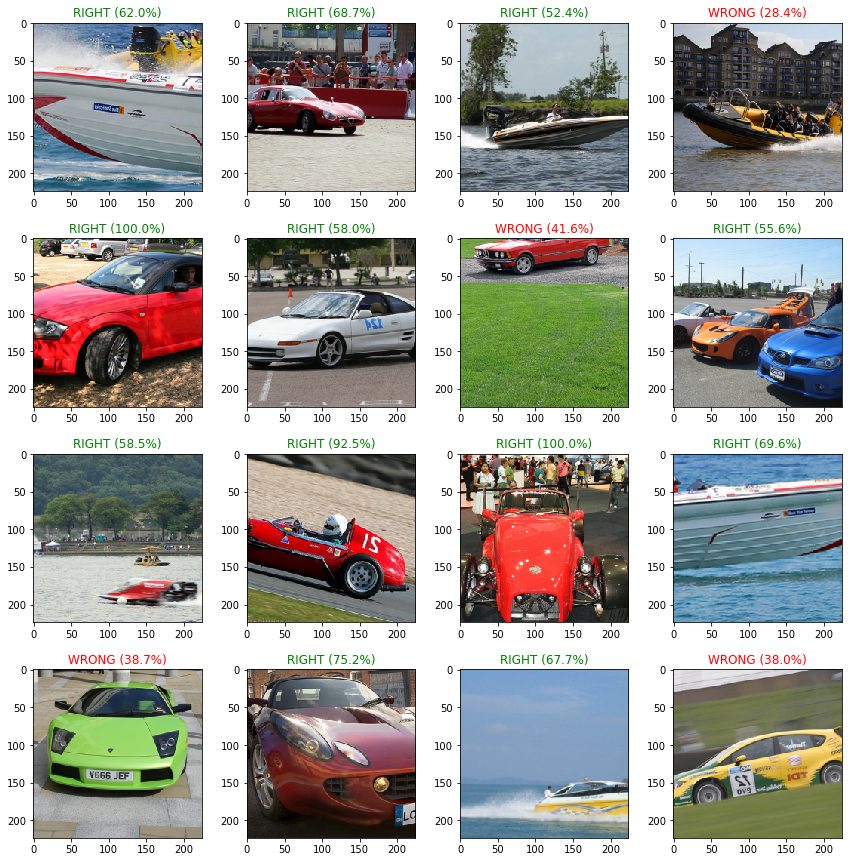

Finished iteration  1/20 (epoch 2/2) (183.07 images/sec)
Finished iteration  2/20 (epoch 2/2) (191.84 images/sec)
Finished iteration  3/20 (epoch 2/2) (192.12 images/sec)
Finished iteration  4/20 (epoch 2/2) (185.70 images/sec)
Finished iteration  5/20 (epoch 2/2) (186.20 images/sec)
Finished iteration  6/20 (epoch 2/2) (184.83 images/sec)
Finished iteration  7/20 (epoch 2/2) (194.01 images/sec)
Finished iteration  8/20 (epoch 2/2) (197.61 images/sec)
Finished iteration  9/20 (epoch 2/2) (196.50 images/sec)
Finished iteration 10/20 (epoch 2/2) (188.11 images/sec)
Finished iteration 11/20 (epoch 2/2) (184.07 images/sec)
Finished iteration 12/20 (epoch 2/2) (188.47 images/sec)
Finished iteration 13/20 (epoch 2/2) (198.43 images/sec)
Finished iteration 14/20 (epoch 2/2) (197.75 images/sec)
Finished iteration 15/20 (epoch 2/2) (196.71 images/sec)
Finished iteration 16/20 (epoch 2/2) (186.34 images/sec)
Finished iteration 17/20 (epoch 2/2) (183.97 images/sec)
Finished iteration 18/20 (epoch

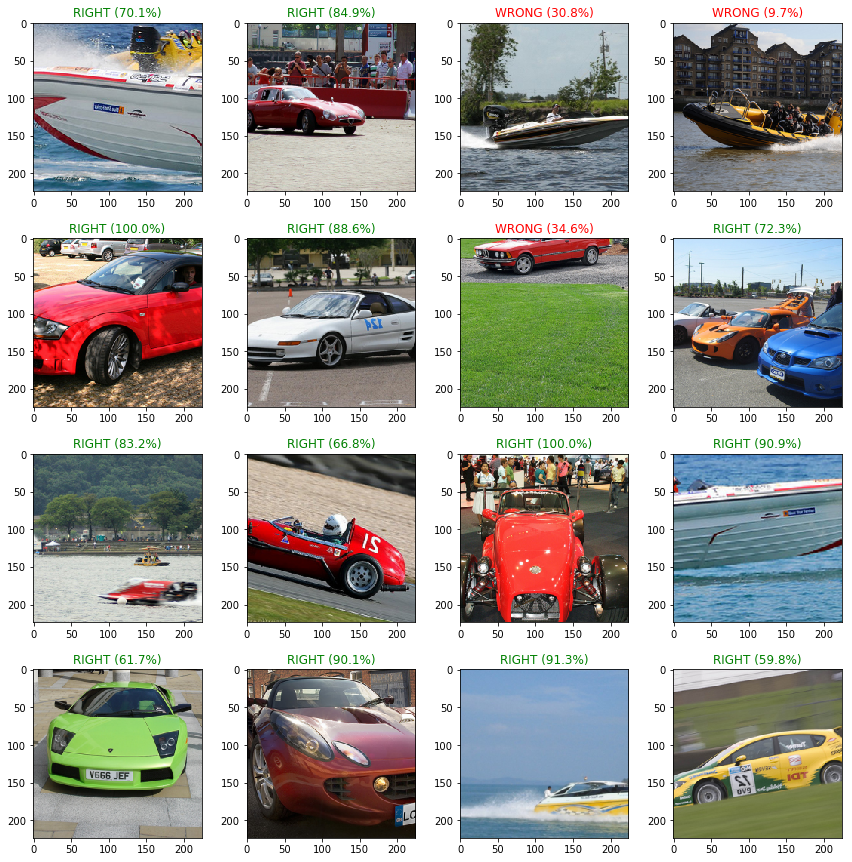

In [60]:
# SOLUTION for Part 11

# Start looping through epochs where we run the batches of images to cover the entire dataset
# Usually you would want to run a lot more epochs to increase your model's accuracy
num_epochs = 2
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1
        
        # Stopwatch stopped! How'd we do?
        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))
        
        # Get the average accuracy for the training model
        train_accuracy = accuracy(train_model)
    
    # Run the test model and assess accuracy
    test_accuracies = []
    for _ in range(test_data_count / total_batch_size):
        # Run the test model
        workspace.RunNet(test_model.net.Proto().name)
        test_accuracies.append(accuracy(test_model))
    test_accuracy = np.average(test_accuracies)

    print(
        "Train accuracy: {:.3f}, test accuracy: {:.3f}".
        format(train_accuracy, test_accuracy))
    
    # Output images with confidence scores as the caption
    display_images_and_confidence()


In [ ]:
# SOLUTION FUNCTIONS FOR BASIC RESNET-50 MODEL WITH ONE GPU

def add_image_input(model):
    # utilize the ImageInput operator to prep the images
    data, label = model.ImageInput(
        reader,
        ["data", "label"],
        batch_size=batch_per_device,
        # mean: to remove color values that are common
        mean=128.,
        # std is going to be modified randomly to influence the mean subtraction
        std=128.,
        # scale to rescale each image to a common size
        scale=256,
        # crop to the square each image to exact dimensions
        crop=224,
        # mirroring of the images will occur randomly
        mirror=1
    )
    # prevent back-propagation: optional performance improvement; may not be observable at small scale
    data = model.StopGradient(data, data)


def create_resnet50_model_ops(model, loss_scale=1.0):
    # Creates a residual network
    [softmax, loss] = resnet.create_resnet50(
        model,
        "data",
        num_input_channels=3,
        num_labels=num_labels,
        label="label",
    )
    prefix = model.net.Proto().name
    loss = model.Scale(loss, prefix + "_loss", scale=loss_scale)
    model.Accuracy([softmax, "label"], prefix + "_accuracy")
    return [loss]


def add_parameter_update_ops(model):
    model.AddWeightDecay(weight_decay)
    # (stepsize moved to config)
    # stepsize = int(10 * train_data_count / total_batch_size)
    iter = model.Iter("iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=stepsize,
        gamma=0.1,
    )
    for param in model.GetParams():
        param_grad = model.param_to_grad[param]
        param_momentum = model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # a defenseman for the Montreal Canadiens, true
            nesterov=1,
        )
        

def optimize_gradient_memory(model, loss):
    model.net._net = memonger.share_grad_blobs(
        model.net,
        loss,
        set(model.param_to_grad.values()),
        # we don't have a namescope in this case
        namescope="myscope",
        share_activations=False,
        )

## Reference Script
You should be able to run the solution blocks above, or these blocks below in order to see a sample output. The program below uses more functions and even has a function factory. It does not run ResNet first with one GPU. It assumes you have more than one GPU and want to use `dpm`.

In [62]:
from caffe2.python import core, workspace, cnn, net_drawer
from caffe2.python import data_parallel_model as dpm
from caffe2.python.models import resnet
# here we don't use pb2 because we using dpm the whole time

import numpy as np
import time
import os
from IPython import display
    
workspace.GlobalInit(['caffe2', '--caffe2_log_level=2'])

# This section checks if you have the training and testing databases
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'resnet_trainer')

# Train/test data
train_data_db = os.path.join(data_folder, "imagenet_cars_boats_train")
train_data_db_type = "lmdb"
# actually 640 cars and 640 boats = 1280
train_data_count = 1280
test_data_db = os.path.join(data_folder, "imagenet_cars_boats_val")
test_data_db_type = "lmdb"
# actually 48 cars and 48 boats = 96
test_data_count = 96

# Get the dataset if it is missing
def DownloadDataset(url, path):
    import requests, zipfile, StringIO
    print "Downloading... ", url, " to ", path
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)

# Make the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
# See if you already have to db, and if not, download it
if not os.path.exists(train_data_db):
    DownloadDataset("https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip", data_folder) 

In [63]:
# PART 2 SOLUTION
# Configure how you want to train the model and with how many GPUs
# This is set to use two GPUs in a single machine, but if you have more GPUs, extend the array [0, 1, 2, n]
gpus = [0, 1]

# Batch size of 32 sums up to roughly 5GB of memory per device
batch_per_device = 32
total_batch_size = batch_per_device * len(gpus)

# This model discriminates between two labels: car or boat
num_labels = 2

# Initial learning rate (scale with total batch size)
base_learning_rate = 0.0004 * total_batch_size

# Weight decay (L2 regularization)
weight_decay = 1e-4

In [70]:
# SOLUTION FOR FUNCTIONS

# Image input operator that loads data from reader and
# applies certain transformations to the images.
# This is a function generator and this method is shown with the create_test_model() function
def add_image_input_fn(reader):
    def add_image_input(model):
        # utilize the ImageInput operator to prep the images
        data, label = model.ImageInput(
            reader,
            ["data", "label"],
            batch_size=batch_per_device,
            # mean: to remove color values that are common
            mean=128.,
            # std is going to be modified randomly to influence the mean subtraction
            std=128.,
            # scale to rescale each image to a common size
            scale=256,
            # crop to the square each image to exact dimensions
            crop=224,
            # mirroring of the images will occur randomly
            mirror=1
        )
        # prevent back-propagation: optional performance improvement; may not be observable at small scale
        data = model.StopGradient(data, data)
    return add_image_input


def create_resnet50_model_ops(model, loss_scale):
    # Creates a residual network
    [softmax, loss] = resnet.create_resnet50(
        model,
        "data",
        num_input_channels=3,
        num_labels=num_labels,
        label="label",
    )
    prefix = model.net.Proto().name
    loss = model.Scale(loss, prefix + "_loss", scale=loss_scale)
    model.Accuracy([softmax, "label"], prefix + "_accuracy")
    return [loss]


def add_momentum_sgd_update(train_model, lr):
    for param in train_model.GetParams():
        param_grad = train_model.param_to_grad[param]
        param_momentum = train_model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        train_model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # a defenseman for the Montreal Canadiens, true
            nesterov=1,
        )
        

def add_parameter_update_ops(model):
    model.AddWeightDecay(weight_decay)
    stepsize = int(10 * train_data_count / total_batch_size)
    iter = model.Iter("iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=stepsize,
        gamma=0.1,
    )
    add_momentum_sgd_update(model, lr)
    


In [71]:
# SOLUTION example for creating the training model
def create_train_model():
    # Use the model helper to create a CNN for us
    train_model = cnn.CNNModelHelper(
        order="NCHW",
        name="train",
    )

    # This training data reader is shared between all GPUs.
    # When reading data, the trainer runs ImageInputOp for each GPU to retrieve their own unique batch of training data.
    # CreateDB comes from model_helper.py
    reader = train_model.CreateDB(
        "train_reader",
        db=train_data_db,
        db_type=train_data_db_type,
    )


    # Create parallelized model
    dpm.Parallelize_GPU(
        train_model,
        # add_image_input_fn is a function generator that returns a model
        input_builder_fun=add_image_input_fn(reader),
        forward_pass_builder_fun=create_resnet50_model_ops,
        param_update_builder_fun=add_parameter_update_ops,
        devices=gpus,
        optimize_gradient_memory=True,
    )


    workspace.RunNetOnce(train_model.param_init_net)
    workspace.CreateNet(train_model.net)
    return train_model

In [72]:
# SOLUTION example for creating the training model
def create_test_model():
    test_model = cnn.CNNModelHelper(
        order="NCHW",
        name="test",
    )

    reader = test_model.CreateDB(
        "test_reader",
        db=test_data_db,
        db_type=test_data_db_type,
    )

    # Validation is parallelized across devices as well
    dpm.Parallelize_GPU(
        test_model,
        input_builder_fun=add_image_input_fn(reader),
        forward_pass_builder_fun=create_resnet50_model_ops,
        param_update_builder_fun=None,
        devices=gpus,
    )

    workspace.RunNetOnce(test_model.param_init_net)
    workspace.CreateNet(test_model.net)
    
    return test_model

In [73]:
# SOLUTION for reporting
%matplotlib inline
from caffe2.python import visualize
from matplotlib import pyplot as plt

def display_images_and_confidence():
    images = []
    confidences = []
    n = 16
    data = workspace.FetchBlob("gpu_0/data")
    label = workspace.FetchBlob("gpu_0/label")
    softmax = workspace.FetchBlob("gpu_0/softmax")
    for arr in zip(data[0:n], label[0:n], softmax[0:n]):
        # CHW to HWC, normalize to [0.0, 1.0], and BGR to RGB
        bgr = (arr[0].swapaxes(0, 1).swapaxes(1, 2) + 1.0) / 2.0
        rgb = bgr[...,::-1]
        images.append(rgb)
        confidences.append(arr[2][arr[1]])

    # Create grid for images
    fig, rows = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    plt.tight_layout(h_pad=2)

    # Display images and the models confidence in their label
    items = zip([ax for cols in rows for ax in cols], images, confidences)
    for (ax, image, confidence) in items:
        ax.imshow(image)
        if confidence >= 0.5:
            ax.set_title("RIGHT ({:.1f}%)".format(confidence * 100.0), color='green')
        else:
            ax.set_title("WRONG ({:.1f}%)".format(confidence * 100.0), color='red')

    plt.show()

    
def accuracy(model):
    accuracy = []
    prefix = model.net.Proto().name
    for device in model._devices:
        accuracy.append(
            np.asscalar(workspace.FetchBlob("gpu_{}/{}_accuracy".format(device, prefix))))
    return np.average(accuracy)

Finished iteration  1/20 (epoch 1/2) (75.64 images/sec)
Finished iteration  2/20 (epoch 1/2) (192.03 images/sec)
Finished iteration  3/20 (epoch 1/2) (189.25 images/sec)
Finished iteration  4/20 (epoch 1/2) (193.64 images/sec)
Finished iteration  5/20 (epoch 1/2) (189.71 images/sec)
Finished iteration  6/20 (epoch 1/2) (195.13 images/sec)
Finished iteration  7/20 (epoch 1/2) (192.15 images/sec)
Finished iteration  8/20 (epoch 1/2) (193.69 images/sec)
Finished iteration  9/20 (epoch 1/2) (195.13 images/sec)
Finished iteration 10/20 (epoch 1/2) (194.66 images/sec)
Finished iteration 11/20 (epoch 1/2) (195.93 images/sec)
Finished iteration 12/20 (epoch 1/2) (196.51 images/sec)
Finished iteration 13/20 (epoch 1/2) (194.54 images/sec)
Finished iteration 14/20 (epoch 1/2) (197.23 images/sec)
Finished iteration 15/20 (epoch 1/2) (187.54 images/sec)
Finished iteration 16/20 (epoch 1/2) (186.99 images/sec)
Finished iteration 17/20 (epoch 1/2) (186.92 images/sec)
Finished iteration 18/20 (epoch 

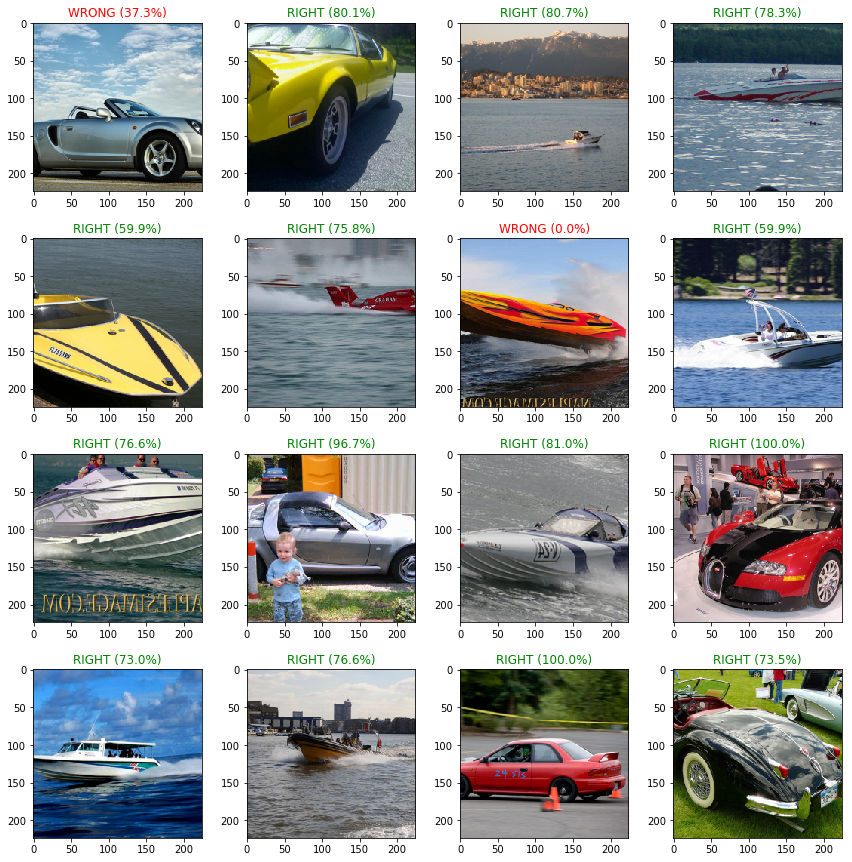

Finished iteration  1/20 (epoch 2/2) (201.16 images/sec)
Finished iteration  2/20 (epoch 2/2) (192.49 images/sec)
Finished iteration  3/20 (epoch 2/2) (197.56 images/sec)
Finished iteration  4/20 (epoch 2/2) (199.56 images/sec)
Finished iteration  5/20 (epoch 2/2) (196.00 images/sec)
Finished iteration  6/20 (epoch 2/2) (199.71 images/sec)
Finished iteration  7/20 (epoch 2/2) (198.82 images/sec)
Finished iteration  8/20 (epoch 2/2) (199.55 images/sec)
Finished iteration  9/20 (epoch 2/2) (198.95 images/sec)
Finished iteration 10/20 (epoch 2/2) (198.86 images/sec)
Finished iteration 11/20 (epoch 2/2) (197.86 images/sec)
Finished iteration 12/20 (epoch 2/2) (199.51 images/sec)
Finished iteration 13/20 (epoch 2/2) (198.29 images/sec)
Finished iteration 14/20 (epoch 2/2) (197.71 images/sec)
Finished iteration 15/20 (epoch 2/2) (198.92 images/sec)
Finished iteration 16/20 (epoch 2/2) (198.94 images/sec)
Finished iteration 17/20 (epoch 2/2) (201.29 images/sec)
Finished iteration 18/20 (epoch

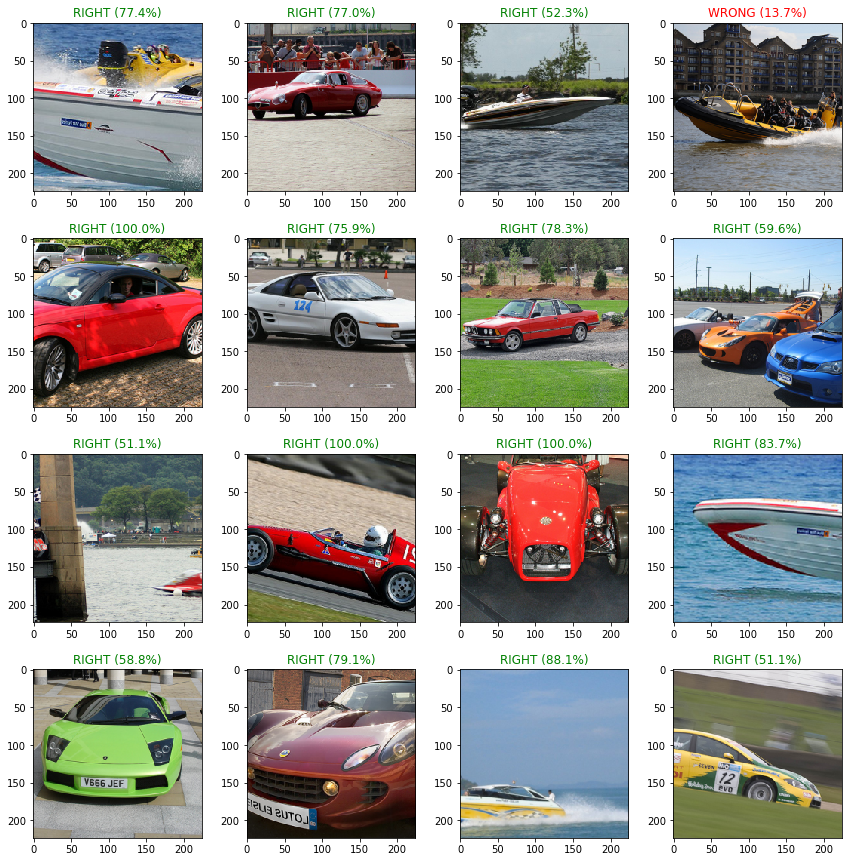

In [74]:
# Initialize the training model and the test model
# A few major steps are here when you create_train_model and create_test_model:
# 1) use CNNModelHelper to create CNN
# 2) create a database reader to pull the images
# 3) create the parallelized model
train_model = create_train_model()
test_model = create_test_model()

# Start looping through epochs where we run the batches of images to cover the entire dataset
# Usually you would want to run a lot more epochs to increase your model's accuracy
num_epochs = 2
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1
        
        # Stopwatch stopped! How'd we do?
        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))
        
        # Get the average accuracy for the training model
        train_accuracy = accuracy(train_model)
    
    # Run the test model and assess accuracy
    test_accuracies = []
    for _ in range(test_data_count / total_batch_size):
        # Run the test model
        workspace.RunNet(test_model.net.Proto().name)
        test_accuracies.append(accuracy(test_model))
    test_accuracy = np.average(test_accuracies)

    print(
        "Train accuracy: {:.3f}, test accuracy: {:.3f}".
        format(train_accuracy, test_accuracy))
    
    # Output images with confidence scores as the caption
    display_images_and_confidence()


### TO DO:
(or things to explore on your own to improve this tutorial!)
* Create your own database of images
* Explore the layers
* Print out images of the intermediates/activations to show what's happening under the hood
* Make some interactions between epochs (change of params to show impact)